In [102]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',150)

%matplotlib inline

In [103]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
test  = pd.read_csv('https://raw.githubusercontent.com/nikipi/Text_as_data/master/Tweet_sentiment/test_tweets_anuFYb8.csv')
train = pd.read_csv('https://raw.githubusercontent.com/nikipi/Text_as_data/master/Tweet_sentiment/train_E6oV3lV.csv')

In [104]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


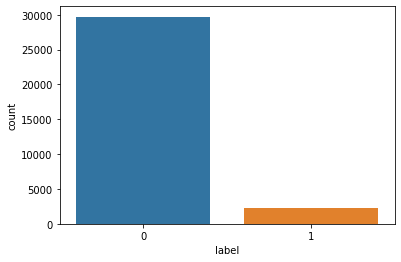

In [105]:
import seaborn as sns

sns.countplot(x='label', data=train)

In [106]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

## Unbalanced target variable-- undersampling or upsampling

In [107]:
from sklearn.utils import resample

In [108]:
train_majority=train[train['label']==0]
train_minority=train[train['label']==1]

In [109]:
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=29720,    # to match majority class
                                 random_state=123) # reproducible results

In [110]:
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

In [111]:
train_upsampled.label.value_counts()

1    29720
0    29720
Name: label, dtype: int64

## Preprocess the text

In [112]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z1-9]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [113]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [138]:
X = []
sentences = list(train_upsampled['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [139]:
X[2]

' bihday your majesty'

In [140]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer



In [142]:
y=train_upsampled ['label']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Word Embedding

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

In [145]:
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

print(X_train_vectorized.shape)
print(X_test_vectorized.shape)


(47552, 34109)
(11888, 34109)


## Logistic Regression

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

/Users/apple/PycharmProjects/PRACTICE/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC:  0.9817720363778003


## Dense Neural Network

In [122]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



In [123]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [124]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [125]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3383000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 3,393,001
Trainable params: 10,001
Non-trainable params: 3,383,000
_________________________________________________________________
None


In [126]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 20455 samples, validate on 5114 samples
Epoch 1/6
20455/20455 [==============================] - 1s 72us/step - loss: 0.2629 - acc: 0.9304 - val_loss: 0.2532 - val_acc: 0.9284
Epoch 2/6
20455/20455 [==============================] - 1s 51us/step - loss: 0.2465 - acc: 0.9306 - val_loss: 0.2492 - val_acc: 0.9284
Epoch 3/6
20455/20455 [==============================] - 1s 55us/step - loss: 0.2421 - acc: 0.9306 - val_loss: 0.2466 - val_acc: 0.9284
Epoch 4/6
20455/20455 [==============================] - 1s 44us/step - loss: 0.2394 - acc: 0.9306 - val_loss: 0.2469 - val_acc: 0.9284
Epoch 5/6
20455/20455 [==============================] - 1s 48us/step - loss: 0.2364 - acc: 0.9306 - val_loss: 0.2418 - val_acc: 0.9284
Epoch 6/6
20455/20455 [==============================] - 1s 58us/step - loss: 0.2341 - acc: 0.9306 - val_loss: 0.2414 - val_acc: 0.9284


In [127]:
score = model.evaluate(X_test, y_test, verbose=1)

6393/6393 [==============================] - 0s 46us/step


In [128]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.23748750044168412
Test Accuracy: 0.9286719560623169


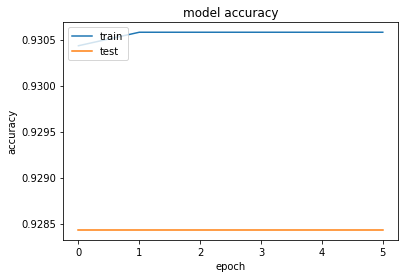

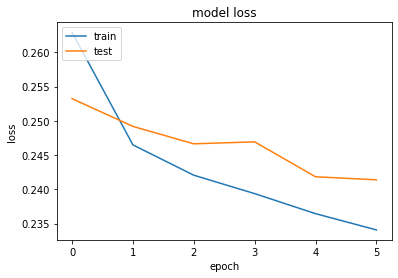

In [129]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Convolutional Neural Network

In [130]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

embedding_layer = Embedding(vocab_size, 100,input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [131]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 20455 samples, validate on 5114 samples
Epoch 1/6
20455/20455 [==============================] - 13s 617us/step - loss: 0.2765 - acc: 0.9300 - val_loss: 0.2503 - val_acc: 0.9284
Epoch 2/6
20455/20455 [==============================] - 13s 625us/step - loss: 0.2344 - acc: 0.9314 - val_loss: 0.2320 - val_acc: 0.9304
Epoch 3/6
20455/20455 [==============================] - 11s 558us/step - loss: 0.2110 - acc: 0.9348 - val_loss: 0.2141 - val_acc: 0.9341
Epoch 4/6
20455/20455 [==============================] - 10s 502us/step - loss: 0.1903 - acc: 0.9384 - val_loss: 0.2013 - val_acc: 0.9361
Epoch 5/6
20455/20455 [==============================] - 13s 613us/step - loss: 0.1742 - acc: 0.9418 - val_loss: 0.1932 - val_acc: 0.9392
Epoch 6/6
6393/6393 [==============================] - 1s 203us/step


In [132]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.18417452226571965
Test Accuracy: 0.939152181148529


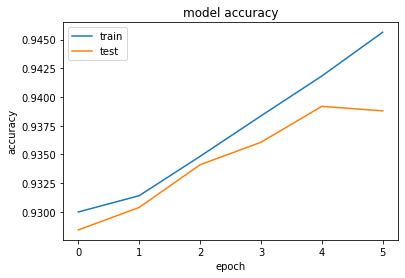

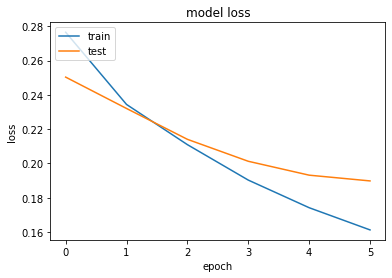

In [133]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM

In [134]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100,input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [135]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 20455 samples, validate on 5114 samples
Epoch 1/6
20455/20455 [==============================] - 61s 3ms/step - loss: 0.2683 - acc: 0.9306 - val_loss: 0.2609 - val_acc: 0.9284
Epoch 2/6
20455/20455 [==============================] - 53s 3ms/step - loss: 0.2526 - acc: 0.9306 - val_loss: 0.2592 - val_acc: 0.9284
Epoch 3/6
20455/20455 [==============================] - 54s 3ms/step - loss: 0.2527 - acc: 0.9306 - val_loss: 0.2578 - val_acc: 0.9284
Epoch 4/6
20455/20455 [==============================] - 54s 3ms/step - loss: 0.2527 - acc: 0.9306 - val_loss: 0.2582 - val_acc: 0.9284
Epoch 5/6
20455/20455 [==============================] - 52s 3ms/step - loss: 0.2523 - acc: 0.9306 - val_loss: 0.2584 - val_acc: 0.9284
Epoch 6/6
6393/6393 [==============================] - 9s 1ms/step


In [136]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2577510796791508
Test Accuracy: 0.9286719560623169


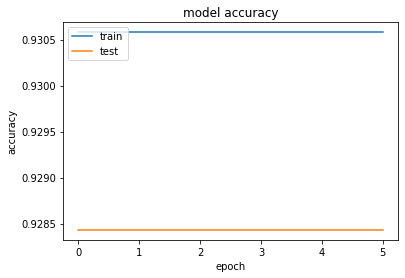

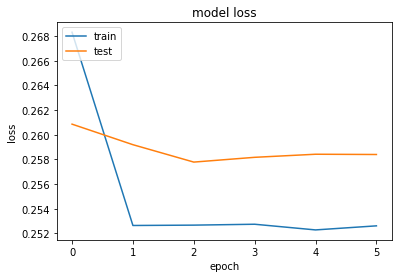

In [137]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()